In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from pyepo.model.grb import tspDFJModel, tspGGModel
# set solver
optmodel = tspDFJModel(num_node)
optmodel_gg = tspGGModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 57.6036
0 -> 5 -> 8 -> 10 -> 4 -> 12 -> 1 -> 17 -> 3 -> 16 -> 9 -> 18 -> 7 -> 2 -> 11 -> 13 -> 19 -> 6 -> 14 -> 15 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [5]:
from dataset import optDatasetConstrs
# get training and test data set
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train) # with binding constr
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test) # without binding constr

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.45it/s]


In [6]:
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols) # with binding constr

Obtaining constraints for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 78.17it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-1, num_epochs+1)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time
from earlystop import earlyStopper

def train(reg, loss_func, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    # init log
    loss_log = []
    regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
    regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
    # running time
    elapsed = 0
    for epoch in range(num_epochs):
        tick = time.time()
        for data in loader_train:
            x, w, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = loss_func(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
        # record time
        tock = time.time()
        elapsed += tock - tick
        if (epoch+1) % log_step == 1:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
            regret_log_val.append(regret_val)
            print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                  format(epoch, loss.item(), regret_trn*100, regret_val*100))
            # early stop
            if stopper.stop(regret_val):
                print("Early Stop!")
                break
    print("Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

### 2-Stage 

In [11]:
# init model
reg = LinearRegression()

In [12]:
from torch import nn
# init loss
mse = nn.MSELoss()

In [13]:
lr = 5e-2
num_epochs = 40
log_step = 2
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# set stopper
stopper = earlyStopper(patience=3)
# init log
loss_log = []
regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train_cost:
        x, c, _, _ = data
        # forward pass
        cp = reg(x)
        loss = mse(cp, c)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log_val.append(regret_val)
        print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
              format(epoch, loss.item(), regret_trn*100, regret_val*100))
        # early stop
        if stopper.stop(regret_val):
            print("Early Stop!")
            break
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  38.7168, Train Regret:  23.5634%, Val Regret:  24.2035%
Epoch   2, Loss:  19.6914, Train Regret:  20.6207%, Val Regret:  21.2920%
Epoch   4, Loss:  11.6140, Train Regret:  17.7841%, Val Regret:  18.1309%
Epoch   6, Loss:  11.0386, Train Regret:  15.2335%, Val Regret:  15.4861%
Epoch   8, Loss:  11.0897, Train Regret:  13.7046%, Val Regret:  14.0917%
Epoch  10, Loss:  11.6637, Train Regret:  13.3480%, Val Regret:  13.5892%
Epoch  12, Loss:   9.1067, Train Regret:  13.1886%, Val Regret:  13.3625%
Epoch  14, Loss:  11.2403, Train Regret:  13.1236%, Val Regret:  13.3992%
Epoch  16, Loss:   7.0397, Train Regret:  13.1238%, Val Regret:  13.1981%
Epoch  18, Loss:  12.4067, Train Regret:  13.0694%, Val Regret:  13.4331%
Epoch  20, Loss:  14.1639, Train Regret:  13.1171%, Val Regret:  13.3801%
Epoch  22, Loss:   9.5777, Train Regret:  12.9935%, Val Regret:  13.2235%
Early Stop!
Elapsed Time: 1.38 Sec


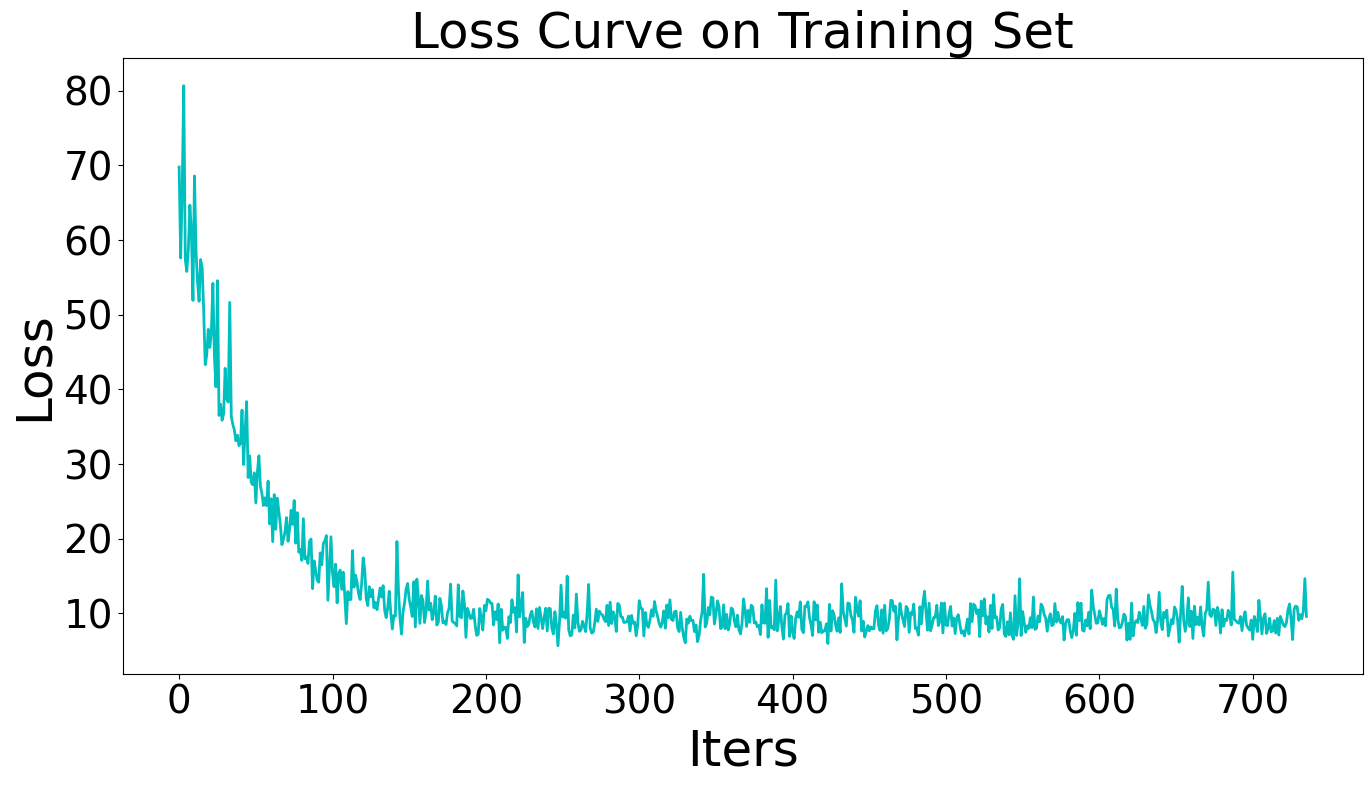

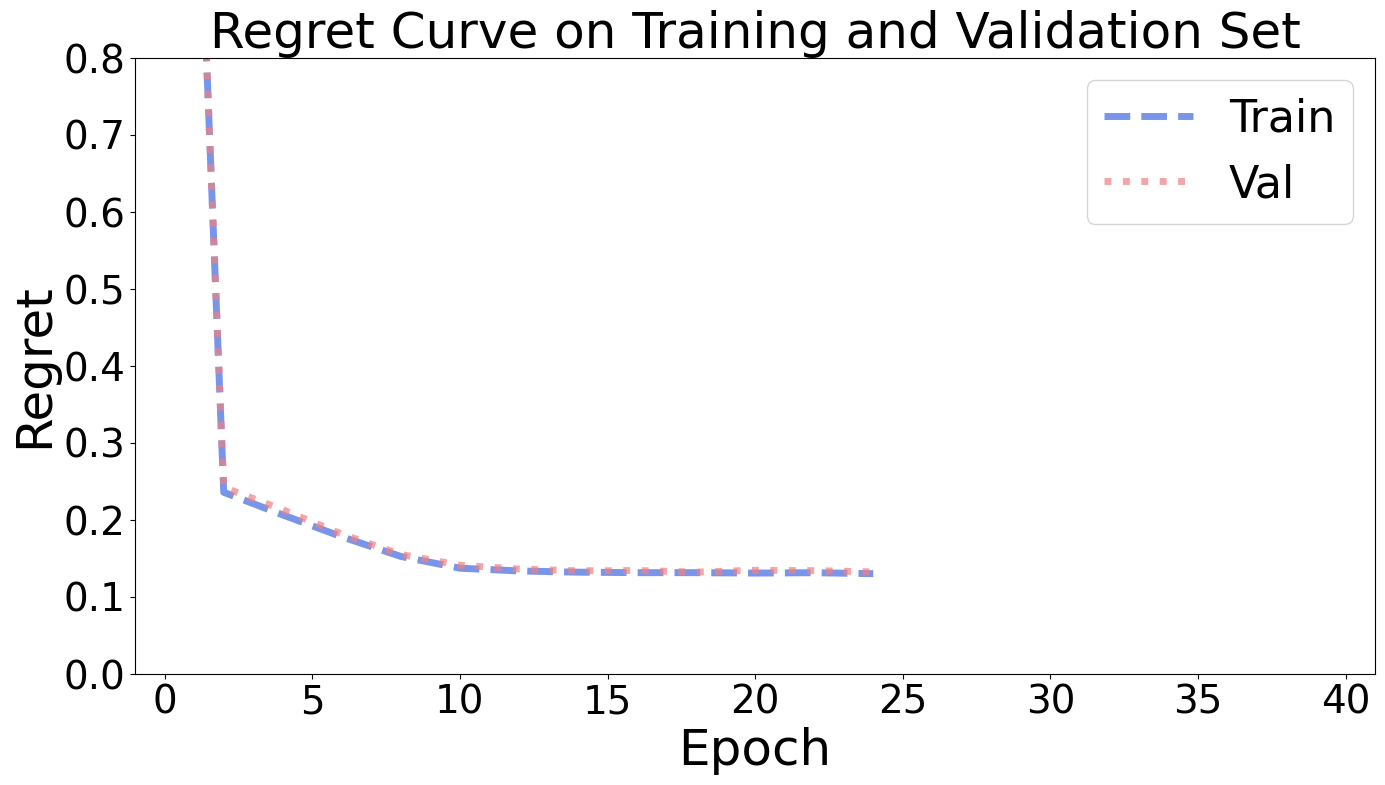

In [14]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method 

In [15]:
# init model
reg = LinearRegression()

In [16]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel)

In [17]:
lr = 5e-2
num_epochs = 40
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9966, Train Regret:  11.9429%, Val Regret:  12.6854%
Epoch   2, Loss:  -0.9989, Train Regret:   7.5861%, Val Regret:   8.4362%
Epoch   4, Loss:  -0.9993, Train Regret:   7.2637%, Val Regret:   7.8397%
Epoch   6, Loss:  -0.9994, Train Regret:   7.2133%, Val Regret:   7.8189%
Epoch   8, Loss:  -0.9998, Train Regret:   7.3076%, Val Regret:   8.0457%
Epoch  10, Loss:  -0.9993, Train Regret:   7.2571%, Val Regret:   8.1363%
Epoch  12, Loss:  -0.9998, Train Regret:   7.2865%, Val Regret:   8.0549%
Early Stop!
Elapsed Time: 216.16 Sec


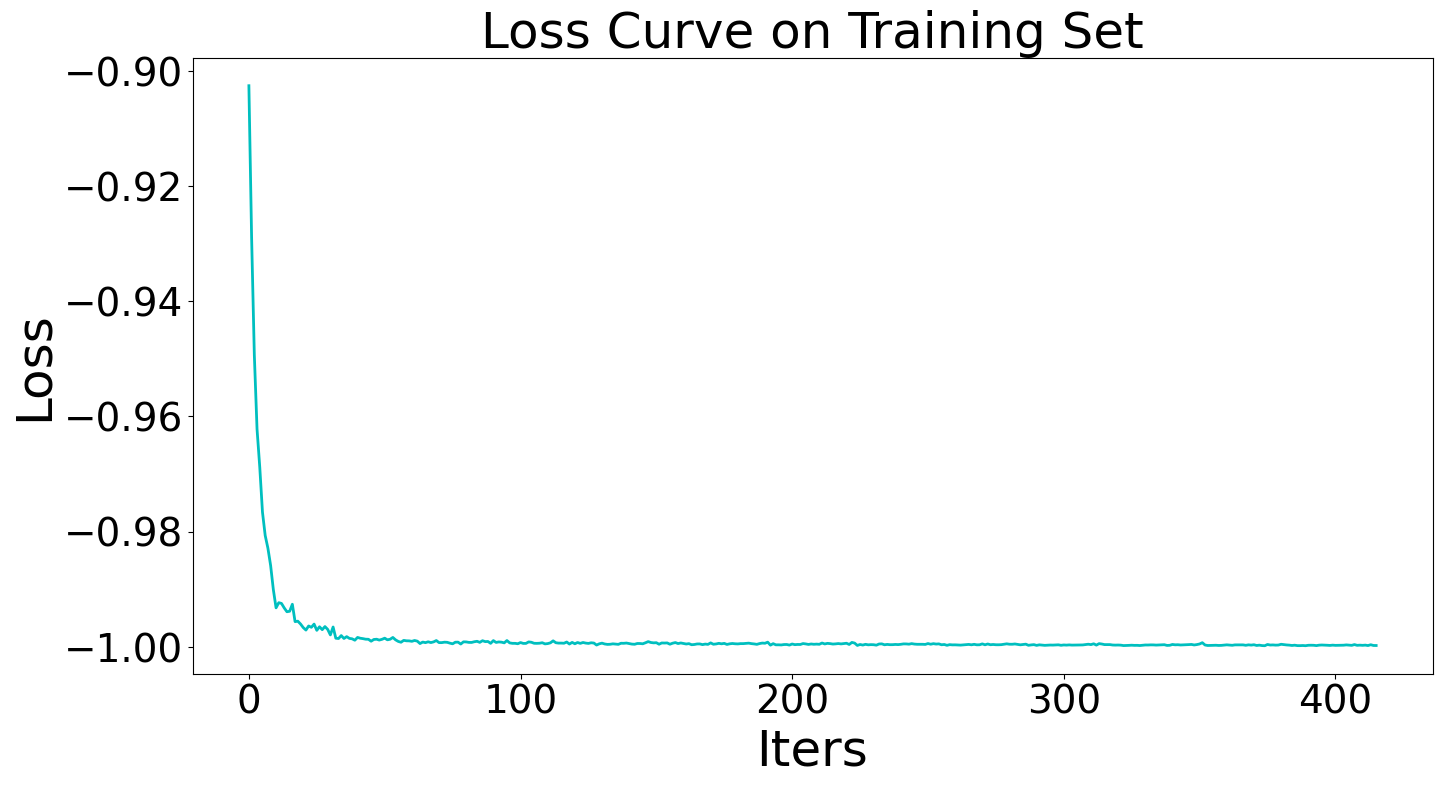

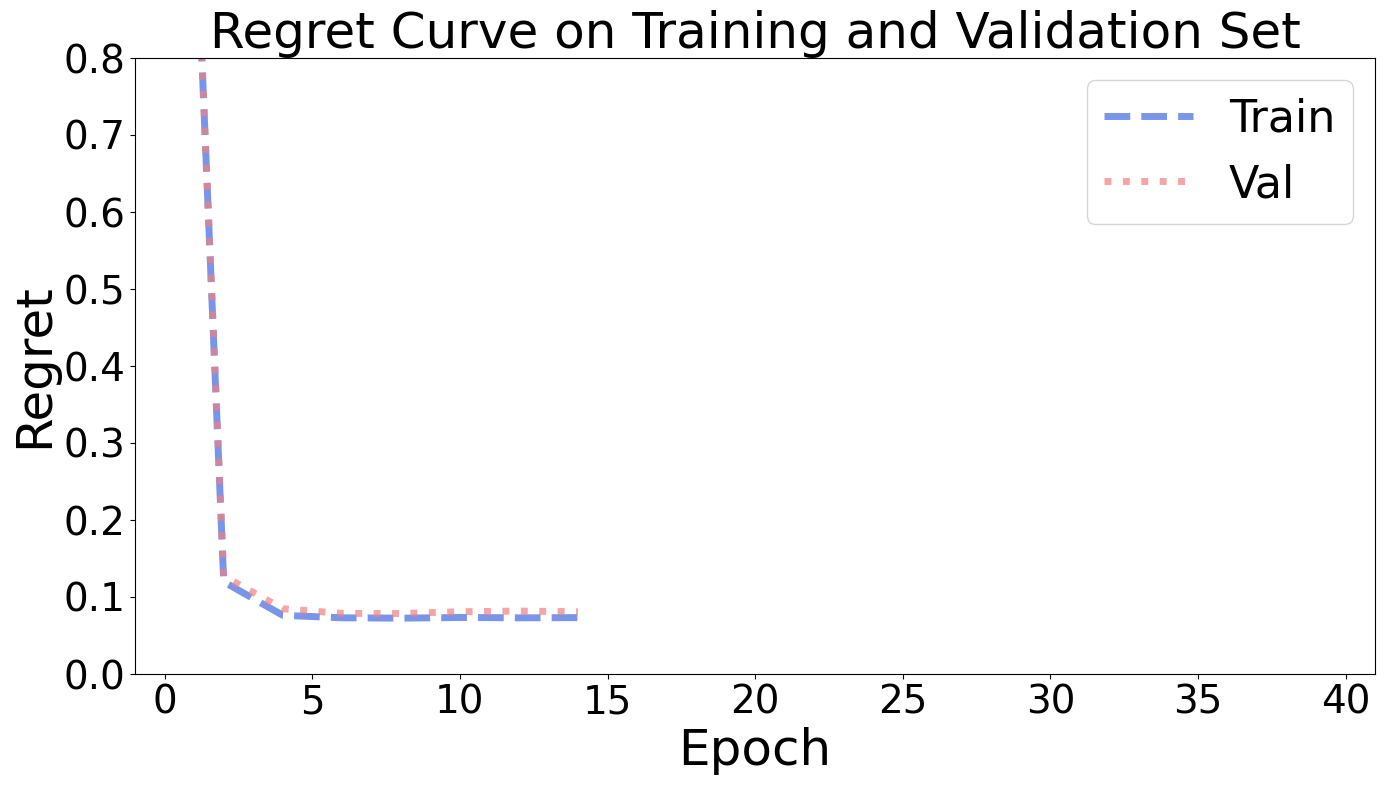

In [18]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NNLS Method 

In [19]:
# init model
reg = LinearRegression()

In [20]:
from func import nnlsConeAlignedCosine
# init loss
ca_cos = nnlsConeAlignedCosine(optmodel)

In [21]:
lr = 5e-2
num_epochs = 40
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9962, Train Regret:  12.7090%, Val Regret:  13.6319%
Epoch   2, Loss:  -0.9995, Train Regret:   7.9273%, Val Regret:   8.3026%
Epoch   4, Loss:  -0.9993, Train Regret:   7.1351%, Val Regret:   7.9759%
Epoch   6, Loss:  -0.9994, Train Regret:   7.1140%, Val Regret:   7.8351%
Epoch   8, Loss:  -0.9997, Train Regret:   7.0942%, Val Regret:   7.8130%
Epoch  10, Loss:  -0.9997, Train Regret:   7.0547%, Val Regret:   7.7209%
Epoch  12, Loss:  -0.9995, Train Regret:   7.2102%, Val Regret:   8.0267%
Epoch  14, Loss:  -0.9997, Train Regret:   7.1327%, Val Regret:   7.8591%
Epoch  16, Loss:  -0.9997, Train Regret:   7.4536%, Val Regret:   8.3022%
Early Stop!
Elapsed Time: 177.53 Sec


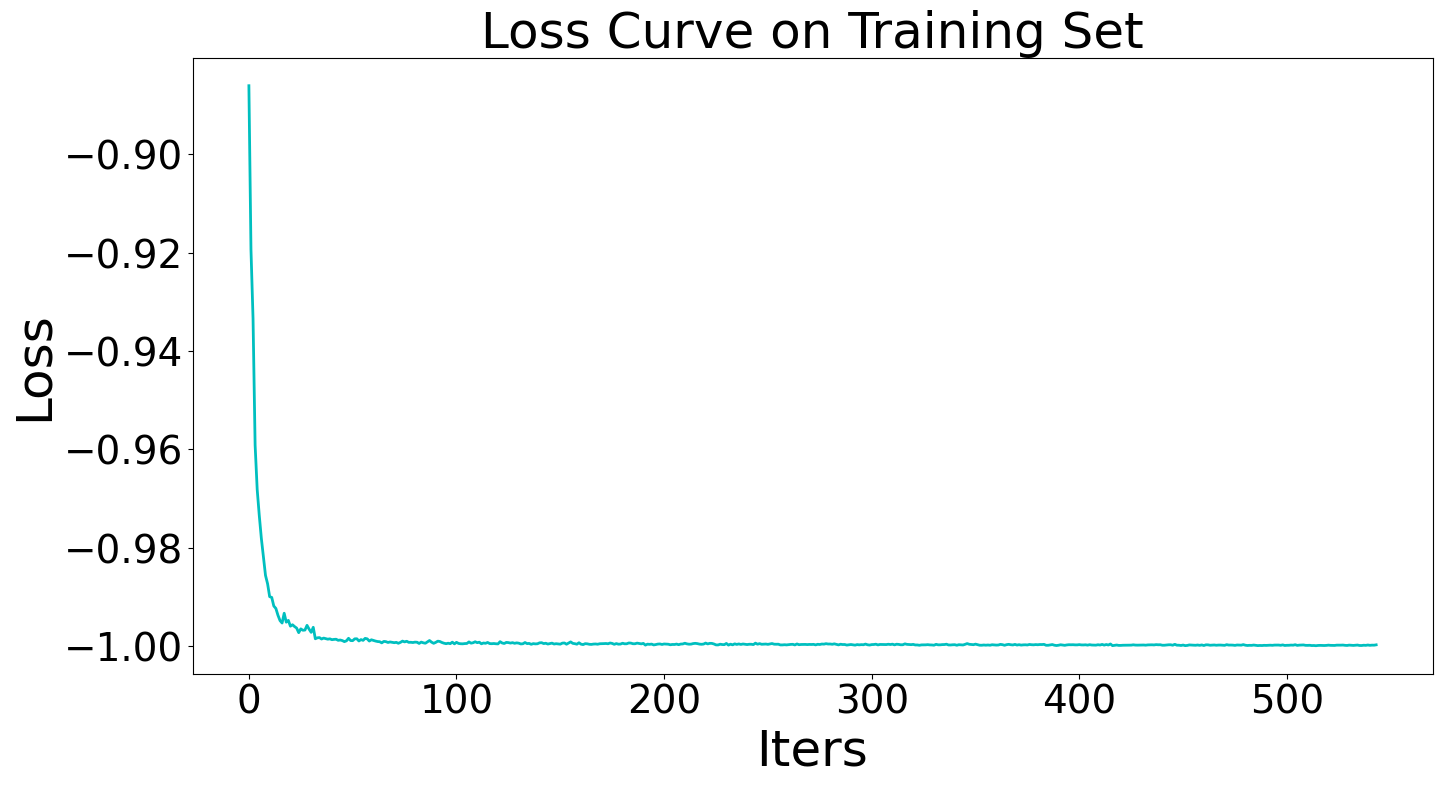

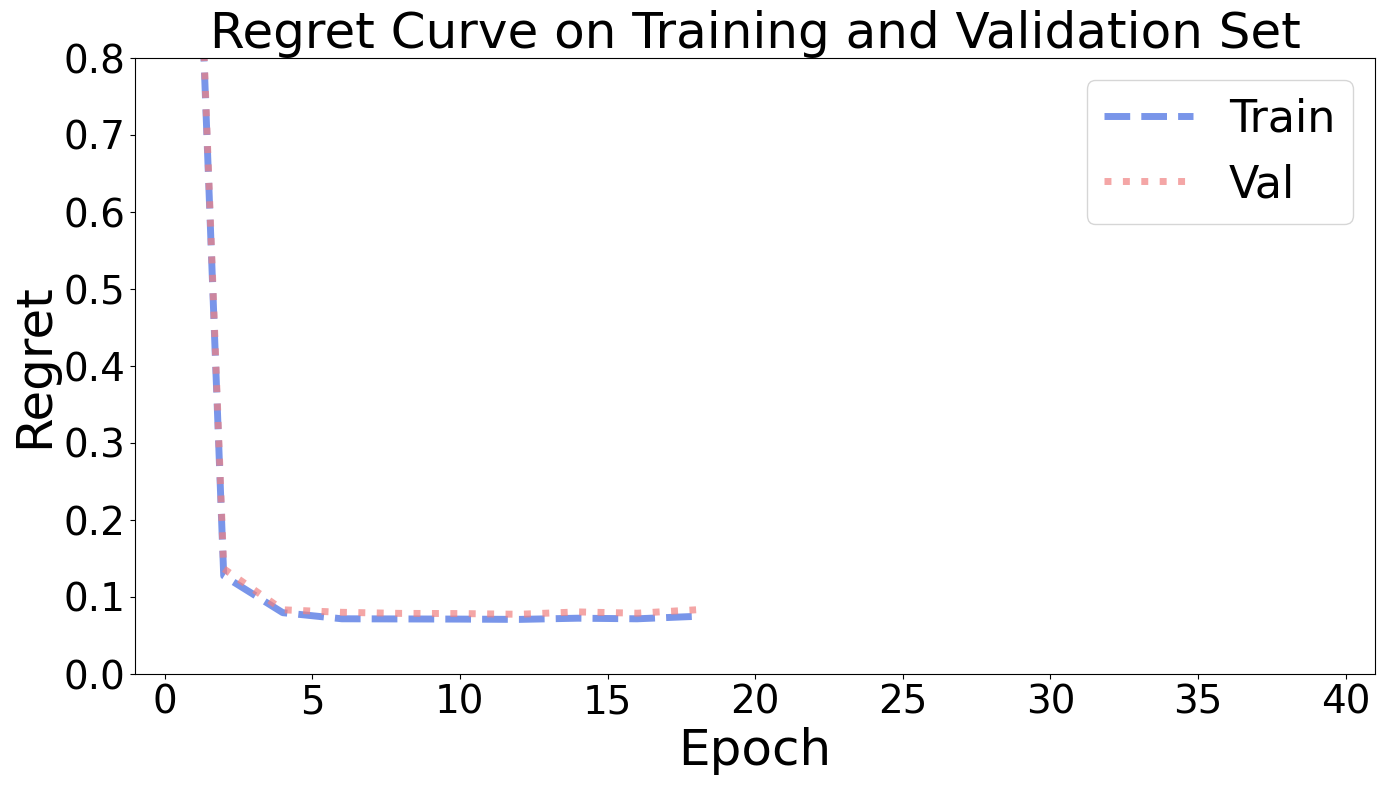

In [22]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [23]:
# init model
reg = LinearRegression()

In [24]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [25]:
lr = 5e-2
num_epochs = 40
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.7707, Train Regret:  20.1543%, Val Regret:  20.6424%
Epoch   2, Loss:  -0.8206, Train Regret:  15.1076%, Val Regret:  15.9494%
Epoch   4, Loss:  -0.8130, Train Regret:  15.1603%, Val Regret:  16.1496%
Epoch   6, Loss:  -0.8301, Train Regret:  14.3359%, Val Regret:  14.8272%
Epoch   8, Loss:  -0.8070, Train Regret:  15.5013%, Val Regret:  15.8633%
Epoch  10, Loss:  -0.8142, Train Regret:  15.2652%, Val Regret:  15.6543%
Epoch  12, Loss:  -0.8238, Train Regret:  15.0529%, Val Regret:  15.8430%
Early Stop!
Elapsed Time: 10.21 Sec


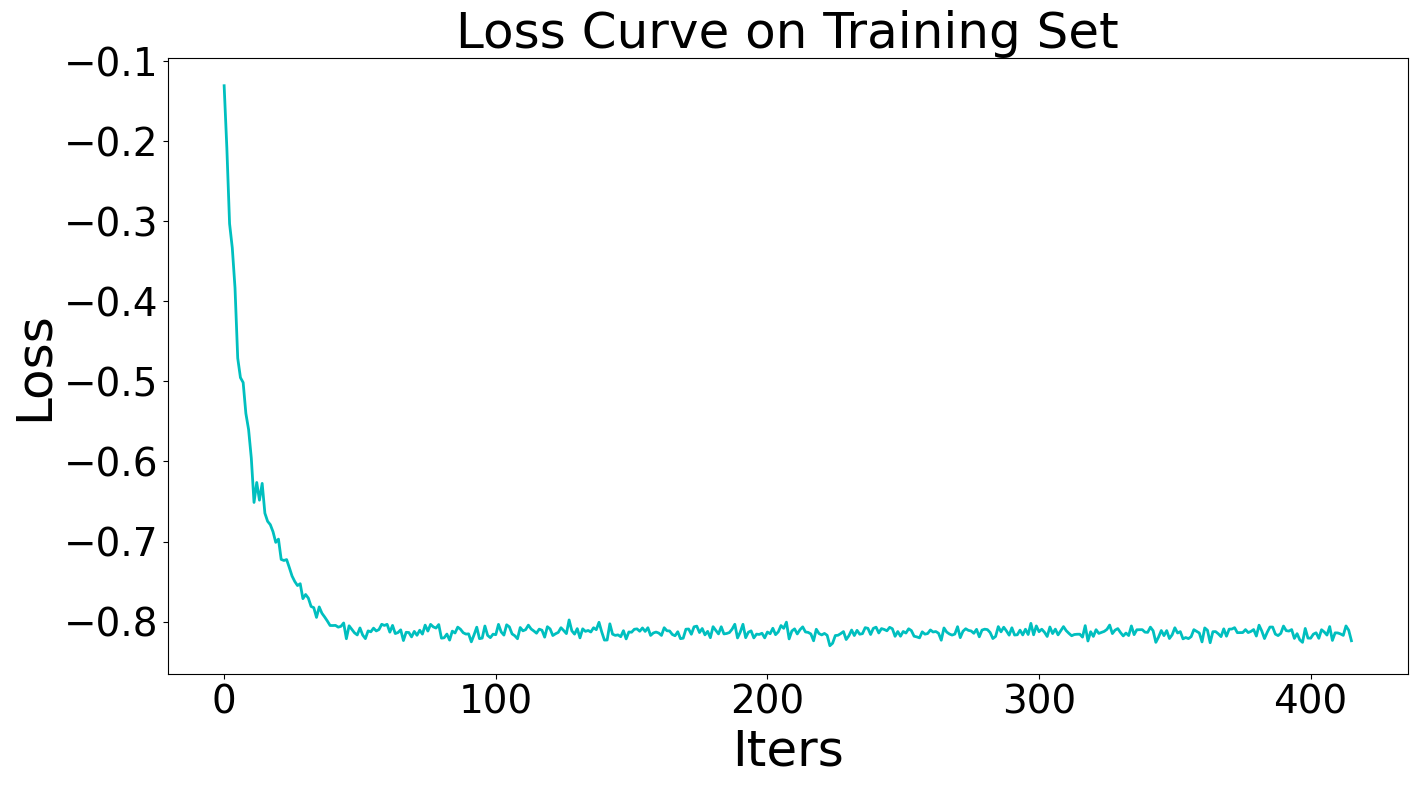

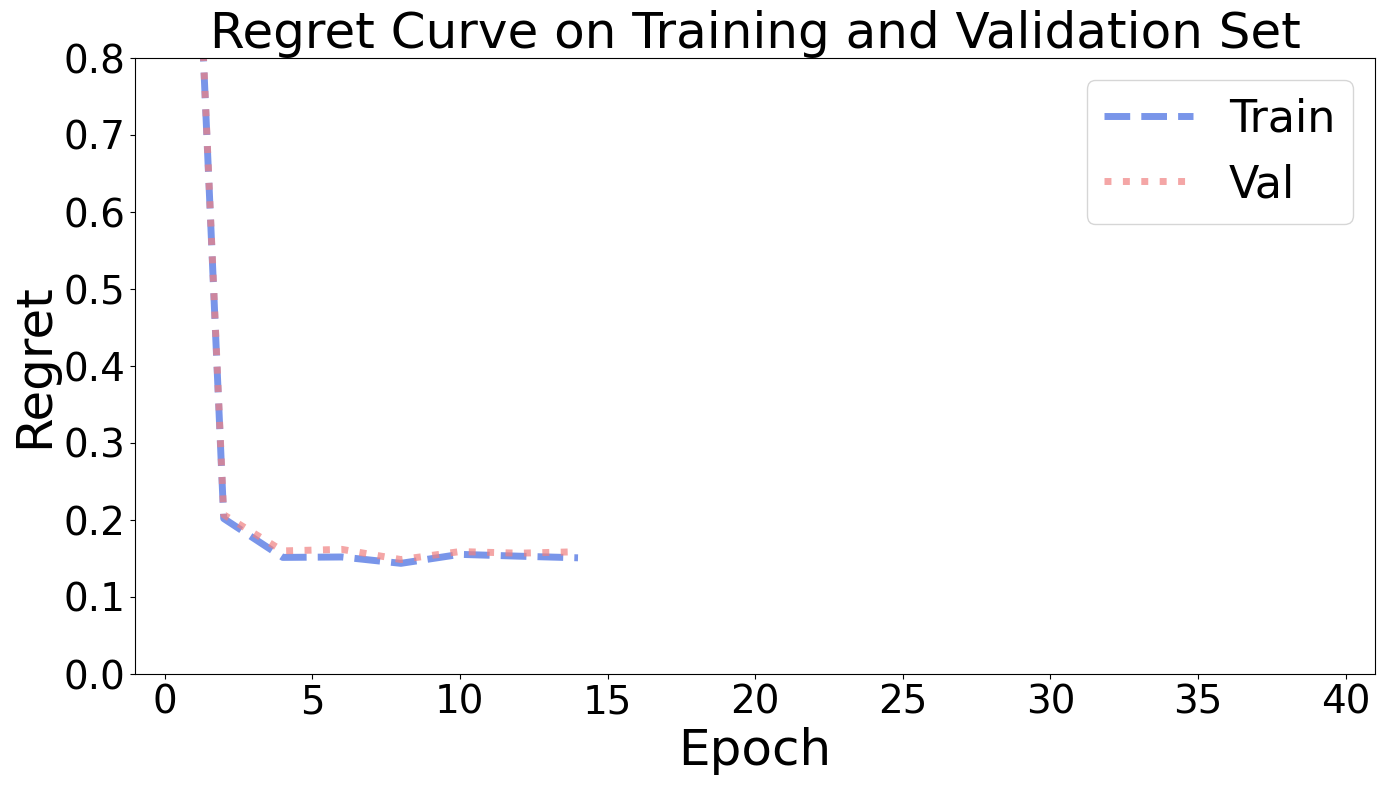

In [26]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sign Method 

In [27]:
# init model
reg = LinearRegression()

In [28]:
from func import signConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel)

In [29]:
lr = 5e-2
num_epochs = 40
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9905, Train Regret:  18.9468%, Val Regret:  19.9495%
Epoch   2, Loss:  -0.9966, Train Regret:   9.4047%, Val Regret:   9.6046%
Epoch   4, Loss:  -0.9979, Train Regret:   8.7901%, Val Regret:   8.9493%
Epoch   6, Loss:  -0.9945, Train Regret:   8.9913%, Val Regret:   9.9619%
Epoch   8, Loss:  -0.9967, Train Regret:  11.0384%, Val Regret:  12.4564%
Epoch  10, Loss:  -0.9979, Train Regret:  14.8534%, Val Regret:  15.9297%
Early Stop!
Elapsed Time: 4.12 Sec


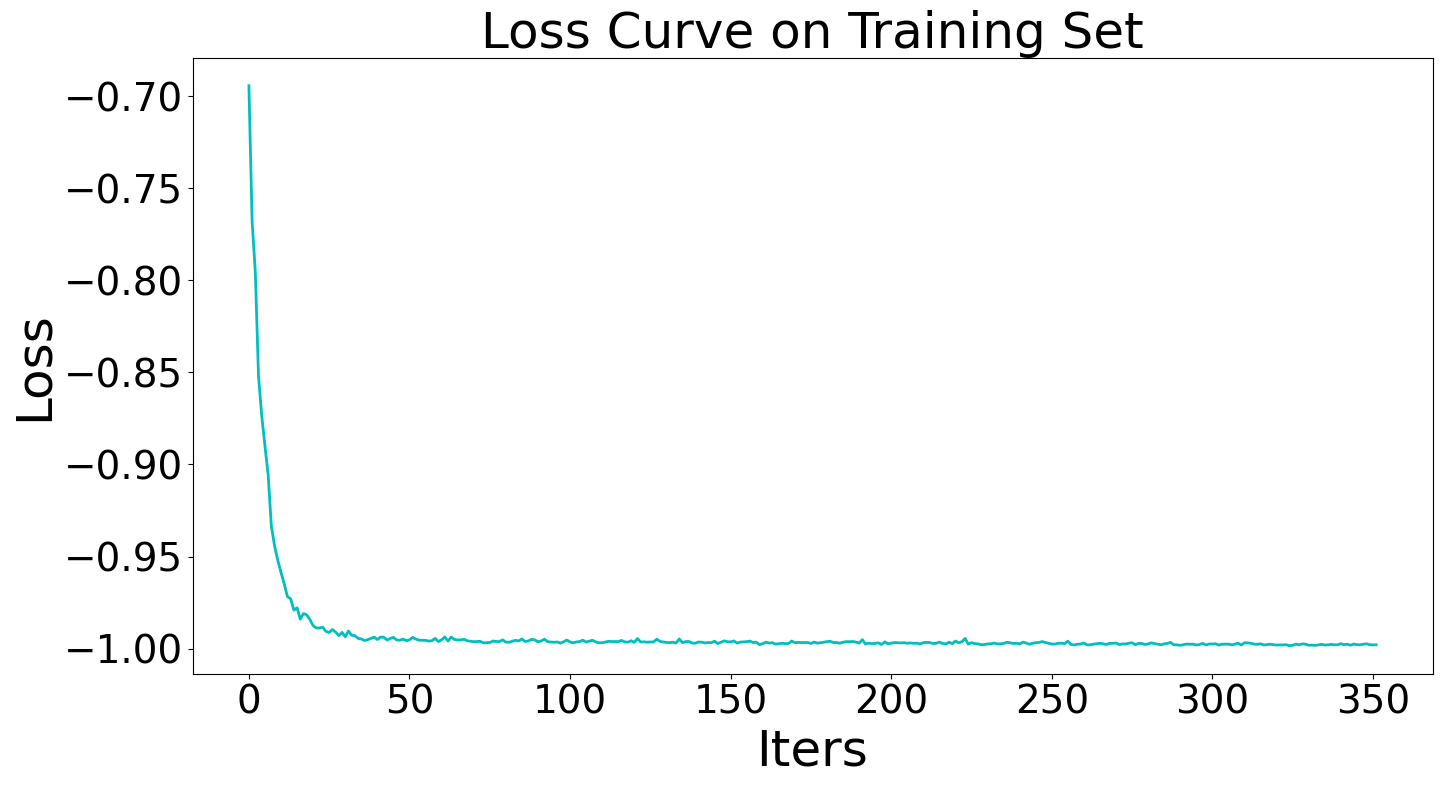

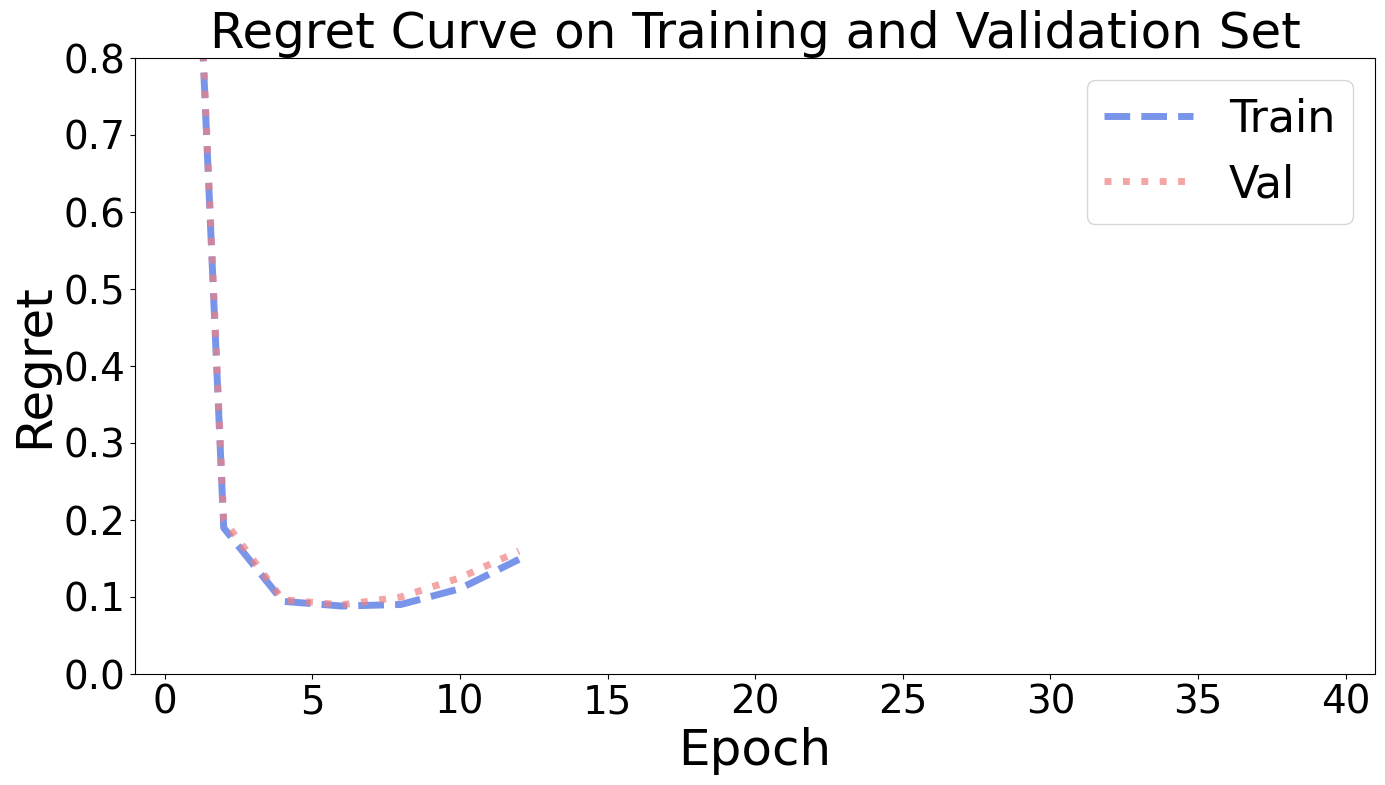

In [30]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [31]:
# init model
reg = LinearRegression()

In [32]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=3, sigma=1.0)

Num of cores: 1


In [33]:
lr = 1e-2
num_epochs = 40
log_step = 2
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# set stopper
stopper = earlyStopper(patience=3)
# init log
loss_log = []
regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train:
        x, w, t_ctr = data
        # forward pass
        cp = reg(x)
        loss = pfy(cp, w)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log_val.append(regret_val)
        print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, loss.item(), regret_trn*100, regret_val*100))
        # early stop
        if stopper.stop(regret_val):
            print("Early Stop!")
            break
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  19.6667, Train Regret:  34.0739%, Val Regret:  34.3253%
Epoch   2, Loss:  14.0000, Train Regret:   9.3500%, Val Regret:   9.8918%
Epoch   4, Loss:  10.1389, Train Regret:   7.0593%, Val Regret:   7.9782%
Epoch   6, Loss:  12.1944, Train Regret:   6.3889%, Val Regret:   7.2545%
Epoch   8, Loss:  11.9167, Train Regret:   6.0392%, Val Regret:   6.9623%
Epoch  10, Loss:  10.5833, Train Regret:   5.7373%, Val Regret:   6.7634%
Epoch  12, Loss:  11.1944, Train Regret:   5.7399%, Val Regret:   6.7540%
Epoch  14, Loss:  10.3889, Train Regret:   5.5671%, Val Regret:   6.5279%
Epoch  16, Loss:  11.1944, Train Regret:   5.5763%, Val Regret:   6.4755%
Epoch  18, Loss:  12.1389, Train Regret:   5.5028%, Val Regret:   6.3527%
Epoch  20, Loss:  10.4444, Train Regret:   5.5164%, Val Regret:   6.4029%
Epoch  22, Loss:  10.4444, Train Regret:   5.3407%, Val Regret:   6.3176%
Epoch  24, Loss:   8.0833, Train Regret:   5.3482%, Val Regret:   6.2438%
Epoch  26, Loss:  11.6111, Train Regre

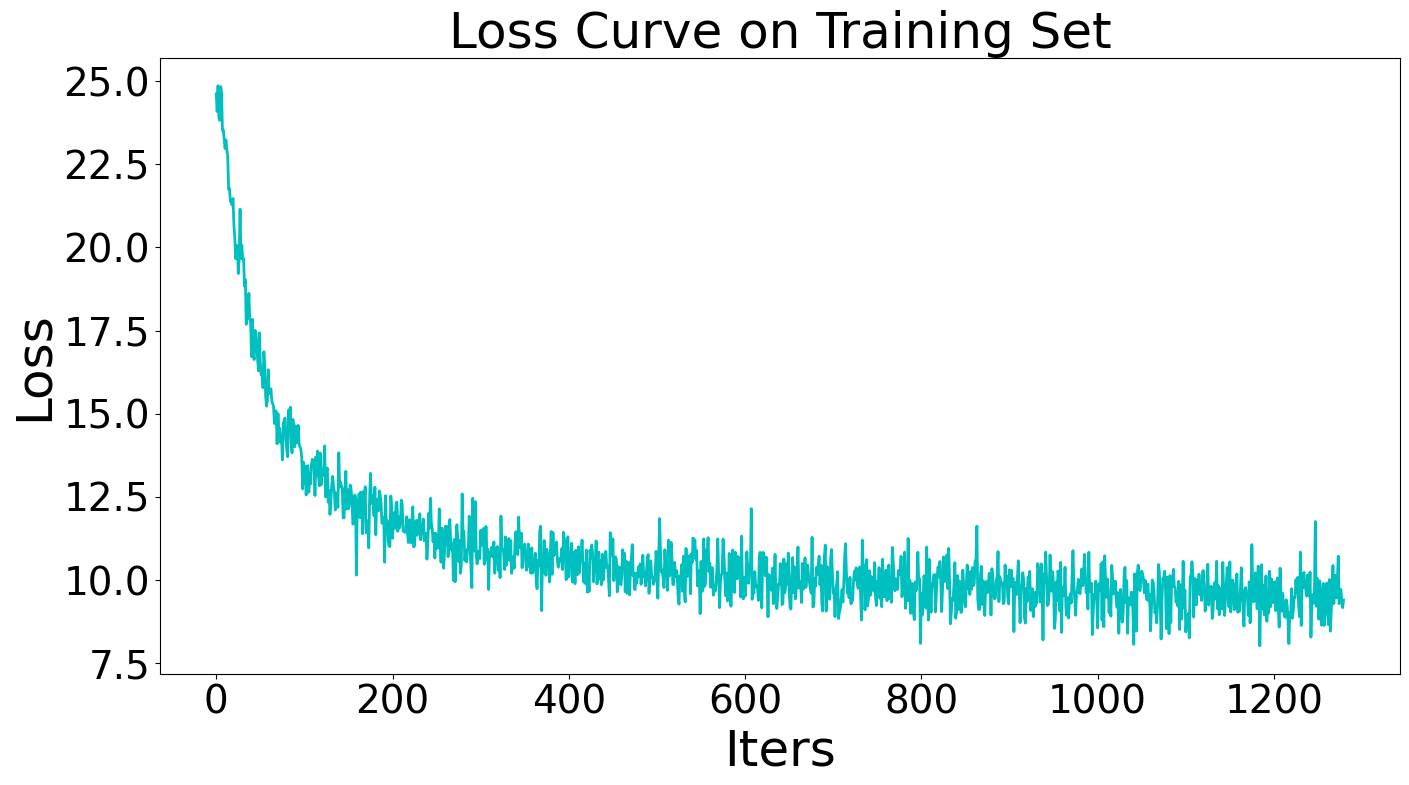

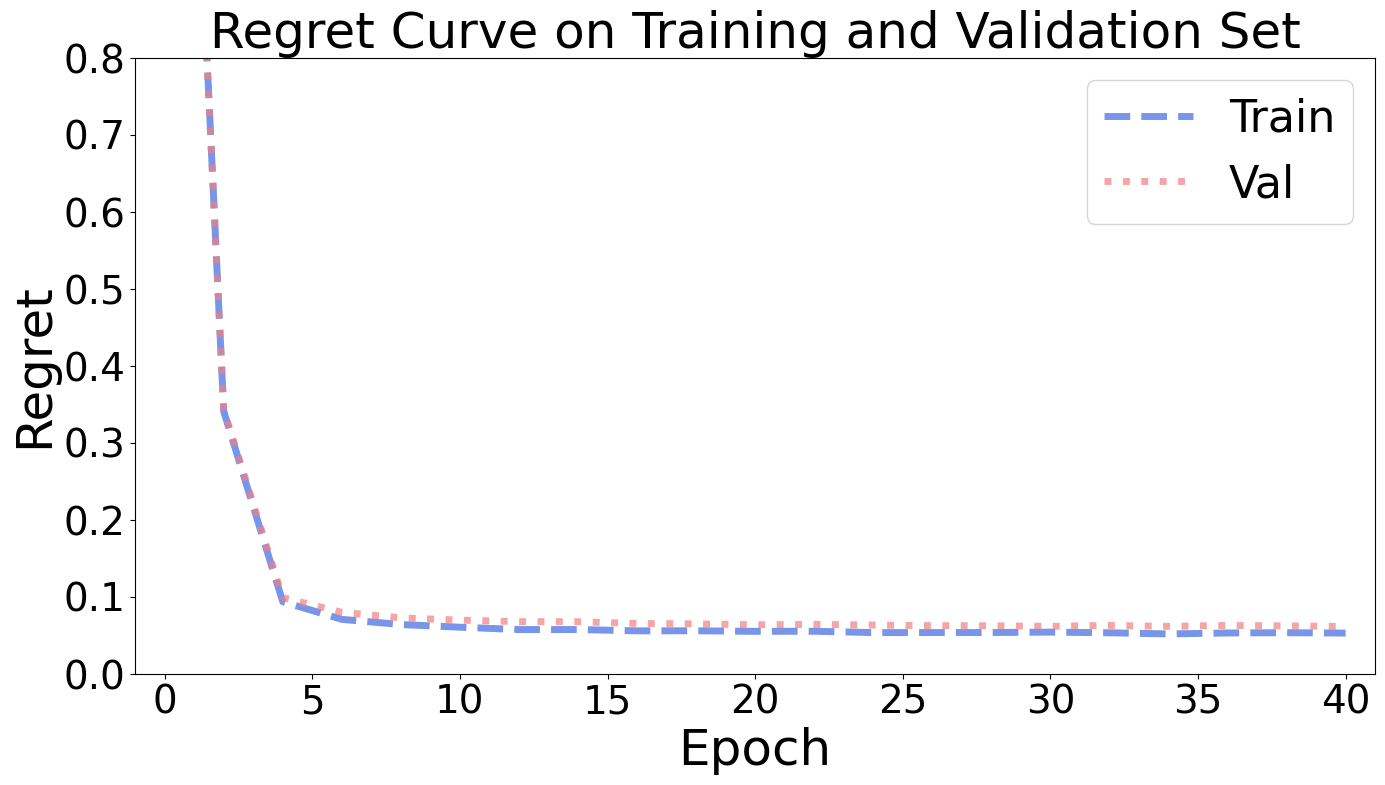

In [34]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)